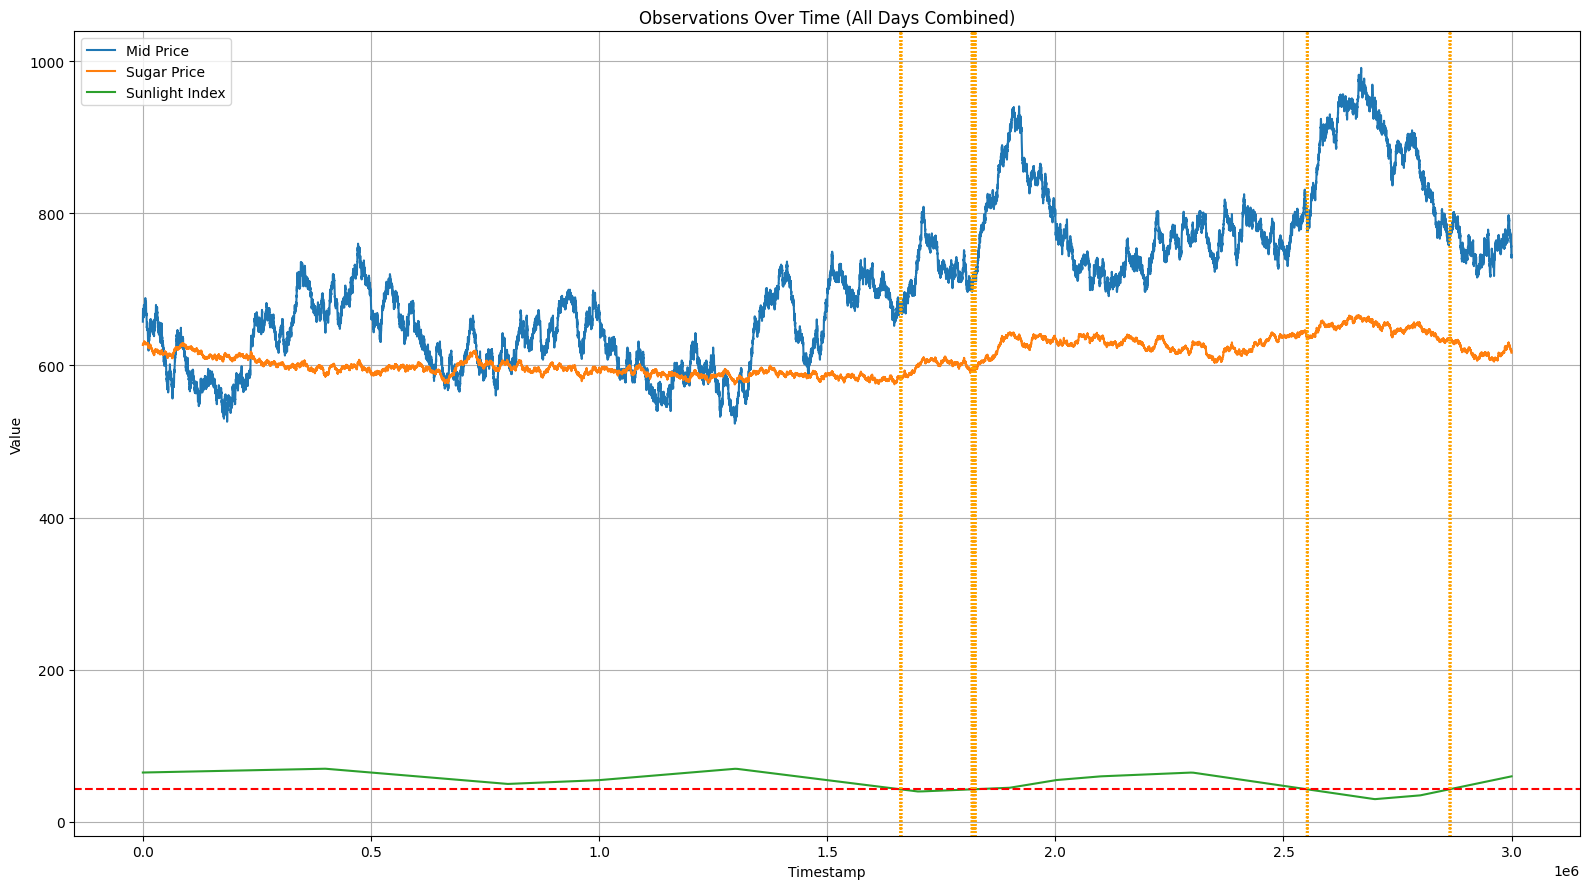

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of file paths
obs_file_paths = [
    "round-5-island-data-bottle/observations_round_5_day_2.csv",
    "round-5-island-data-bottle/observations_round_5_day_3.csv",
    "round-5-island-data-bottle/observations_round_5_day_4.csv",
]

# Read and combine all CSV files, shifting timestamps for each day
obs_dfs = []
for i, path in enumerate(obs_file_paths):
    df = pd.read_csv(path)
    df['timestamp'] += i * 1_000_000  # Shift timestamps per day
    obs_dfs.append(df)

obs_data = pd.concat(obs_dfs, ignore_index=True)

price_file_paths = [
    "round-5-island-data-bottle/prices_round_5_day_2.csv",
    "round-5-island-data-bottle/prices_round_5_day_3.csv",
    "round-5-island-data-bottle/prices_round_5_day_4.csv",
]

# Read and combine all CSV files, shifting timestamps for each day
price_dfs = []
for i, path in enumerate(price_file_paths):
    df = pd.read_csv(path, sep=';')
    df = df[df["product"] == "MAGNIFICENT_MACARONS"]
    df['timestamp'] += i * 1_000_000  # Shift timestamps per day
    price_dfs.append(df)

price_data = pd.concat(price_dfs, ignore_index=True)

data = pd.merge(obs_data, price_data[["timestamp", "mid_price"]], on="timestamp", how="inner")

threshold = 43
tolerance = 0.1

crossing_points = data[np.isclose(data['sunlightIndex'], threshold, atol=tolerance)]


# Plotting all relevant features
plt.figure(figsize=(16, 9))

plt.plot(data['timestamp'], data['mid_price'], label='Mid Price')
# plt.plot(data['timestamp'], data['bidPrice'], label='Bid Price', alpha=0.3)
# plt.plot(data['timestamp'], data['askPrice'], label='Ask Price', alpha=0.3)
plt.plot(data['timestamp'], data['sugarPrice'] * 3, label='Sugar Price')
plt.plot(data['timestamp'], data['sunlightIndex'], label='Sunlight Index')
# plt.plot(data['timestamp'], data['transportFees'], label='Transport Fees')
# plt.plot(data['timestamp'], data['exportTariff'], label='Export Tariff')
# plt.plot(data['timestamp'], data['importTariff'], label='Import Tariff')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for ts in crossing_points['timestamp']:
    plt.axvline(x=ts, color='orange', linestyle=':', linewidth=1)

plt.title("Observations Over Time (All Days Combined)")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


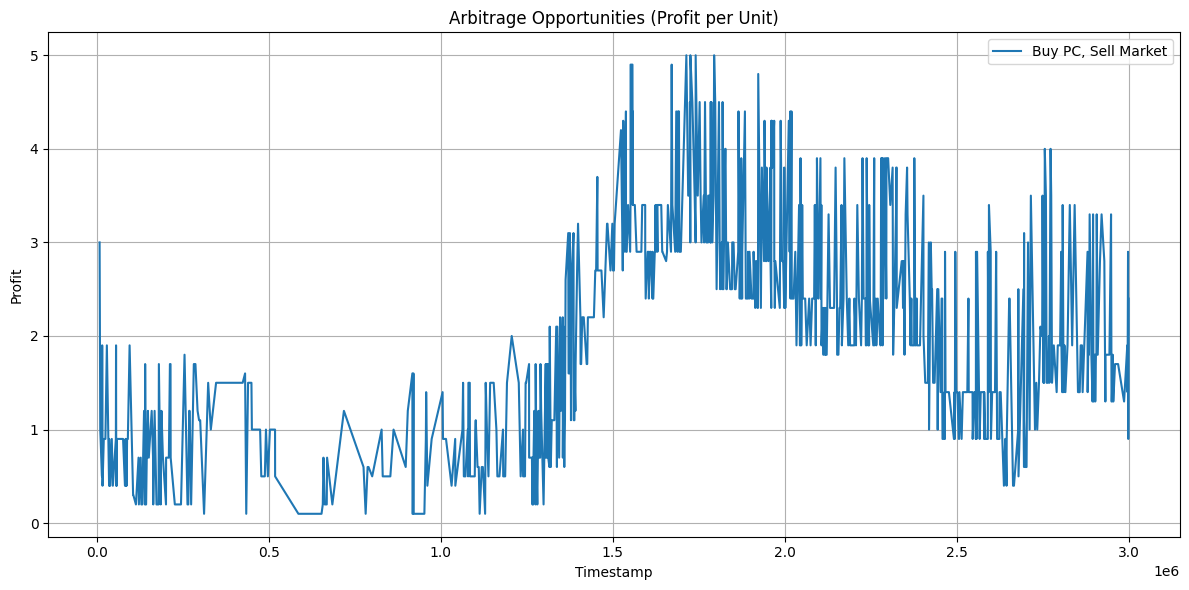

In [2]:
import pandas as pd

# === Load and Merge Data ===

# Observation files
obs_files = [
    "round-5-island-data-bottle/observations_round_5_day_2.csv",
    "round-5-island-data-bottle/observations_round_5_day_3.csv",
    "round-5-island-data-bottle/observations_round_5_day_4.csv",
]

# Price files
price_files = [
    "round-5-island-data-bottle/prices_round_5_day_2.csv",
    "round-5-island-data-bottle/prices_round_5_day_3.csv",
    "round-5-island-data-bottle/prices_round_5_day_4.csv",
]

# Load observations
obs_dfs = []
for i, file in enumerate(obs_files):
    df = pd.read_csv(file)
    df["timestamp"] += i * 1_000_000
    obs_dfs.append(df)
all_obs = pd.concat(obs_dfs, ignore_index=True)

# Load and filter price data for MACARONS
price_dfs = []
for i, file in enumerate(price_files):
    df = pd.read_csv(file, sep=';')
    df = df[df["product"] == "MAGNIFICENT_MACARONS"]
    df["timestamp"] += i * 1_000_000
    price_dfs.append(df)
all_prices = pd.concat(price_dfs, ignore_index=True)

# Merge on timestamp
merged = pd.merge(all_obs, all_prices, on="timestamp", how="inner")

# === Arbitrage Detection ===

opportunities = []

for _, row in merged.iterrows():
    ts = row["timestamp"]
    market_ask = row["ask_price_1"]
    market_bid = row["bid_price_1"]
    pc_buy_cost = row["askPrice"] + row["transportFees"] + row["importTariff"]
    pc_sell_revenue = row["bidPrice"] - row["transportFees"] - row["exportTariff"]

    # Case 1: Buy on Market, Sell to PC
    if market_ask < pc_sell_revenue:
        profit = pc_sell_revenue - market_ask
        opportunities.append((ts, "Buy Market, Sell PC", profit))

    # Case 2: Buy from PC, Sell on Market
    if pc_buy_cost < market_bid:
        profit = market_bid - pc_buy_cost
        opportunities.append((ts, "Buy PC, Sell Market", profit))

# Convert to DataFrame for inspection
arb_df = pd.DataFrame(opportunities, columns=["timestamp", "type", "profit"])
arb_df_sorted = arb_df.sort_values(by="timestamp").reset_index(drop=True)

import matplotlib.pyplot as plt

# === Plot Arbitrage Profits ===
plt.figure(figsize=(12, 6))
for label, group in arb_df_sorted.groupby("type"):
    plt.plot(group["timestamp"], group["profit"], label=label)

plt.title("Arbitrage Opportunities (Profit per Unit)")
plt.xlabel("Timestamp")
plt.ylabel("Profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from randomcolor import RandomColor
from typing import Any

def get_popular_price(row: Any, bid_ask: str) -> int:
    best_price = -1
    max_volume = -1

    for i in range(1, 4):
        volume = getattr(row, f"{bid_ask}_volume_{i}")
        if math.isnan(volume):
            break

        if volume > max_volume:
            best_price = getattr(row, f"{bid_ask}_price_{i}")
            max_volume = volume

    return best_price

def get_product_prices(prices: pd.DataFrame, product: str) -> np.ndarray:
    prices = prices[prices["product"] == product]

    mid_prices = []
    for row in prices.itertuples():
        popular_buy_price = get_popular_price(row, "bid")
        popular_sell_price = get_popular_price(row, "ask")
        mid_price = (popular_buy_price + popular_sell_price) / 2

        if mid_price < 500 and product == "COCONUT_COUPON":
            mid_price = mid_prices[-1]

        mid_prices.append(mid_price)

    return np.array(mid_prices)

def get_prices(round_num: int, day_num: int) -> pd.DataFrame:
    return pd.read_csv(f"round-{round_num}-island-data-bottle/prices_round_{round_num}_day_{day_num}.csv", sep=";")

def get_trades(round_num: int, day_num: int) -> pd.DataFrame:
    return pd.read_csv(f"round-{round_num}-island-data-bottle/trades_round_{round_num}_day_{day_num}.csv", sep=";")

days = [[5, [2, 3, 4]]]

traders = set()

for round_num, day_nums in days:
    for day_num in day_nums:
        trades = get_trades(round_num, day_num)
        traders = traders.union(trades["buyer"])
        traders = traders.union(trades["seller"])

traders = sorted(traders)

combinations = set()

for round_num, day_nums in days:
    for day_num in day_nums:
        trades = get_trades(round_num, day_num)
        for row in trades.itertuples():
            combinations.add((row.buyer, row.seller))

traders

['Caesar',
 'Camilla',
 'Charlie',
 'Gary',
 'Gina',
 'Olga',
 'Olivia',
 'Pablo',
 'Paris',
 'Penelope',
 'Peter']

In [20]:
for round_num, day_nums in days:
    prices = pd.DataFrame()
    trades = pd.DataFrame()

    for day_num in day_nums:
        if len(prices) == 0:
            timestamp_offset = 0
        else:
            timestamp_offset = int(prices["timestamp"].tail(1).iloc[0])

        day_prices = get_prices(round_num, day_num)
        day_trades = get_trades(round_num, day_num)

        day_prices["timestamp"] += timestamp_offset
        day_trades["timestamp"] += timestamp_offset

        prices = pd.concat([prices, day_prices])
        trades = pd.concat([trades, day_trades])

    for product in sorted(prices["product"].unique()):
        product_prices = get_product_prices(prices, product)
        product_trades = trades[trades["symbol"] == product]

        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_trace(go.Scatter(x=prices[prices["product"] == product]["timestamp"], y=product_prices, name="Price", line={"color": "gray"}))

        colors = RandomColor(seed=0)

        for buyer in traders:
            for seller in traders:
                trader_trades = product_trades[(product_trades["buyer"] == buyer) & (product_trades["seller"] == seller)]
                if len(trader_trades) < 2:
                # if seller != "Olivia" and buyer != "Olivia":
                    continue

                fig.add_trace(go.Scatter(
                    x=trader_trades["timestamp"],
                    y=trader_trades["price"],
                    mode="markers",
                    name=f"{seller}->{buyer}",
                    visible="legendonly",
                    line={"color": colors.generate()[0]},
                ))

        fig.update_layout(title_text=f"Round {round_num} - {product}")
        fig.show()